# Compare COSIMA cookbook catalogue to basic intake ESM catalogue

In [1]:
import glob
 
import pathlib

import xarray as xr

from distributed import Client

# xr.backends.file_manager.FILE_CACHE.clear()

In [2]:
# This is really only so that we can visualise the computations that use dask using the dask-dashboard
client = Client()
print(f"Dask dashboard at: {client.dashboard_link}")

Dask dashboard at: http://127.0.0.1:8787/status


## Let's index one experiment containing 5.5TB of data spread across slightly over 2000 netcdf files

In [3]:
index_directory = "/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6"

----------------

## 1. Index and load some data from an experiment using the cosima cookbook approach

### Build the cosima database with a multithreaded client similar to the approach used by `ecgtools` below

In [4]:
import cosima_cookbook as cc

In [5]:
db = "cosima_cookbook_test.db"
session = cc.database.create_session(db)

In [6]:
%%time

cc.database.build_index([index_directory], session)

Indexing experiment: 025deg_jra55_iaf_omip2_cycle6


100%|██████████| 171/171 [00:55<00:00,  3.09it/s]


CPU times: user 4min 42s, sys: 1min 6s, total: 5min 48s
Wall time: 12min 9s


2171

### Load and process/plot some data

In [6]:
%%time

experiment = '025deg_jra55_iaf_omip2_cycle6'

sst = cc.querying.getvar(experiment, "sst", session, ncfile="ocean_month.nc")
area = cc.querying.getvar(experiment, "area_t", session, ncfile="ocean_grid.nc", n=1)

CPU times: user 1.22 s, sys: 175 ms, total: 1.39 s
Wall time: 4.51 s


CPU times: user 1min 1s, sys: 3.45 s, total: 1min 4s
Wall time: 1min 19s


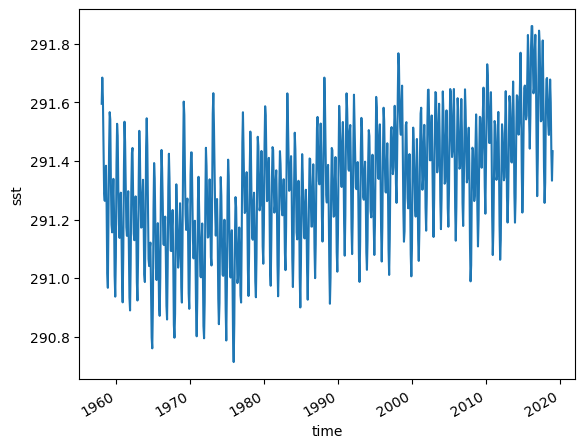

In [7]:
%%time

global_mean = sst.weighted(area.fillna(0)).mean(["xt_ocean", "yt_ocean"])
_ = global_mean.plot()

----------------

## 2. Index and load some data from an experiment using ecgtools and intake-esm

In [4]:
import traceback

import cftime

from ecgtools import Builder
from ecgtools.builder import INVALID_ASSET, TRACEBACK
from ecgtools.parsers.utilities import extract_attr_with_regex

### Build and save the catalogue

In [5]:
from cosima_cookbook import netcdf_utils

def parse_cc(file):
    """Quick hacked parser for COSIMA datasets"""
    def _get_timeinfo(ds):
        """
        Stolen and slightly adapted from cosima cookbook 
        https://github.com/COSIMA/cosima-cookbook/blob/master/cosima_cookbook/database.py#L565
        """
        time_dim = "time" # TODO: this probably shouldn't be hardcoded
        if time_dim is None:
            return None

        time_var = ds[time_dim]
        has_bounds = hasattr(time_var, "bounds") and time_var.bounds in ds.variables
        
        def _todate(t):
            return cftime.num2date(t, time_var.units, calendar=time_var.calendar)
    
        if has_bounds:
            bounds_var = ds.variables[time_var.bounds]
            start_time = _todate(bounds_var[0, 0])
            end_time = _todate(bounds_var[-1, 1])
        else:
            start_time = _todate(time_var[0])
            end_time = _todate(time_var[-1])
        
        if len(time_var) > 1 or has_bounds:
            if has_bounds:
                next_time = _todate(bounds_var[0, 1])
            else:
                next_time = _todate(time_var[1])

            dt = next_time - start_time
            if dt.days >= 365:
                years = round(dt.days / 365)
                frequency = f"{years} yearly"
            elif dt.days >= 28:
                months = round(dt.days / 30)
                frequency = f"{months} monthly"
            elif dt.days >= 1:
                frequency = f"{dt.days} daily"
            else:
                frequency = f"{dt.seconds // 3600} hourly"
        else:
            # single time value in this file and no averaging
            frequency = "static"
            
        return start_time.strftime("%Y-%m-%d"), end_time.strftime("%Y-%m-%d"), frequency
        
    path = pathlib.Path(file)
    
    try:
        path_parts = path.parts
        filename = path.stem
        # TODO: this can be done better
        # First 5 parts are /,g,data,ik11,outputs,access-om2
        experiment = path_parts[6]
        output = path_parts[7]
        realm = path_parts[8]

        with xr.open_dataset(file, chunks={}, decode_times=False) as ds:
            variable_list = [var for var in ds if 'long_name' in ds[var].attrs]

        info = {
                "experiment": experiment,
                "output": output,
                "realm": realm,
                "variables": variable_list,
                'filename': filename,
                "path": str(file),
            }
        info["start_time"], info["end_time"], info["frequency"] = _get_timeinfo(ds)

        return info

    except Exception:
        return {INVALID_ASSET: file, TRACEBACK: traceback.format_exc()}

In [6]:
%%time

cc_builder = Builder(
    index_directory,
    depth=0,
    exclude_patterns=["*/restart*/*"], # Exclude restart directories
    njobs=-1,
)

cc_builder = cc_builder.build(parsing_func=parse_cc)

cc_builder.save(
    "cosima_cookbook_test.csv",
    path_column_name='path',
    variable_column_name='variables',
    data_format="netcdf",
    # Which attributes to groupby when reading in variables using intake-esm
    groupby_attrs=["experiment", "filename"],
    aggregations=[
        {
            "type": "join_existing",
            "attribute_name": "start_time",
            "options": {"dim": "time", "coords": "minimal", "compat": "override"},
        }
    ],
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1440 tasks      | elapsed:   10.9s


Saved catalog location: cosima_cookbook_test.json and cosima_cookbook_test.csv
CPU times: user 1.63 s, sys: 250 ms, total: 1.88 s
Wall time: 15.1 s


[Parallel(n_jobs=-1)]: Done 1891 out of 1891 | elapsed:   13.8s finished


In [8]:
cc_builder.df

,experiment,output,realm,variables,filename,path,start_time,end_time,frequency
0,025deg_jra55_iaf_omip2_cycle6,output305,ice,"[time_bounds, NCAT, tmask, blkmask, tarea, uar...",iceh.1958-01-daily,/g/data/ik11/outputs/access-om2-025/025deg_jra...,1958-01-01,1958-02-01,1 daily
1,025deg_jra55_iaf_omip2_cycle6,output305,ice,"[time_bounds, tmask, blkmask, tarea, uarea, dx...",iceh.1958-01,/g/data/ik11/outputs/access-om2-025/025deg_jra...,1958-01-01,1958-02-01,1 monthly
2,025deg_jra55_iaf_omip2_cycle6,output305,ice,"[time_bounds, NCAT, tmask, blkmask, tarea, uar...",iceh.1958-02-daily,/g/data/ik11/outputs/access-om2-025/025deg_jra...,1958-02-01,1958-03-01,1 daily
3,025deg_jra55_iaf_omip2_cycle6,output305,ice,"[time_bounds, tmask, blkmask, tarea, uarea, dx...",iceh.1958-02,/g/data/ik11/outputs/access-om2-025/025deg_jra...,1958-02-01,1958-03-01,1 monthly
4,025deg_jra55_iaf_omip2_cycle6,output305,ice,"[time_bounds, NCAT, tmask, blkmask, tarea, uar...",iceh.1958-03-daily,/g/data/ik11/outputs/access-om2-025/025deg_jra...,1958-03-01,1958-04-01,1 daily
...,...,...,...,...,...,...,...,...,...
1886,025deg_jra55_iaf_omip2_cycle6,output365,ocean,"[sst, sst_sq, sss, sss_sq, hblt_max, mld, mld_...",ocean_daily,/g/data/ik11/outputs/access-om2-025/025deg_jra...,2017-12-30,2018-12-30,1 daily
1887,025deg_jra55_iaf_omip2_cycle6,output365,ocean,"[ht, hu, dxt, dyt, dxu, dyu, area_t, area_u, k...",ocean_grid,/g/data/ik11/outputs/access-om2-025/025deg_jra...,2018-12-30,2018-12-30,static
1888,025deg_jra55_iaf_omip2_cycle6,output365,ocean,"[pbot_t, patm_t, rho_dzt, dht, sea_level, sea_...",ocean_month,/g/data/ik11/outputs/access-om2-025/025deg_jra...,2017-12-30,2018-12-30,1 monthly
1889,025deg_jra55_iaf_omip2_cycle6,output365,ocean,"[total_mass_seawater, total_volume_seawater, e...",ocean_scalar,/g/data/ik11/outputs/access-om2-025/025deg_jra...,2017-12-30,2018-12-30,1 monthly


In [9]:
# Some files failed to be indexed because they don't have a calendar attribute

cc_builder.invalid_assets.INVALID_ASSET.values

array([PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ocean/o2i.nc'),
       PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output306/ocean/o2i.nc'),
       PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output307/ocean/o2i.nc'),
       PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output308/ocean/o2i.nc'),
       PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output309/ocean/o2i.nc'),
       PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output310/ocean/o2i.nc'),
       PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output311/ocean/o2i.nc'),
       PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output312/ocean/o2i.nc'),
       PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output313/ocean/o2i.nc'),
       Pos

### Open some data
Note, we haven't specified a filename below

In [10]:
import ast

import intake

In [11]:
catalog = intake.open_esm_datastore(
    "cosima_cookbook_test.json",
    read_csv_kwargs={"converters": {"variables": ast.literal_eval}},
    sep="/",
)

In [12]:
%%time

subset = catalog.search(
    experiment="025deg_jra55_iaf_omip2_cycle6", 
    variables="sst")

dsets = subset.to_dataset_dict()
dsets 


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.filename'


CPU times: user 1.72 s, sys: 379 ms, total: 2.1 s
Wall time: 6.67 s


{'025deg_jra55_iaf_omip2_cycle6.ocean_daily': <xarray.Dataset>
 Dimensions:   (time: 22280, yt_ocean: 1080, xt_ocean: 1440)
 Coordinates:
   * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
   * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
   * time      (time) datetime64[ns] 1957-12-30T12:00:00 ... 2018-12-29T12:00:00
 Data variables:
     sst       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(365, 1080, 1440), meta=np.ndarray>
 Attributes:
     filename:                        ocean_daily.nc
     title:                           ACCESS-OM2
     grid_type:                       mosaic
     grid_tile:                       1
     intake_esm_vars:                 ['sst']
     intake_esm_attrs:experiment:     025deg_jra55_iaf_omip2_cycle6
     intake_esm_attrs:realm:          ocean
     intake_esm_attrs:variables:      sst,sst_sq,sss,sss_sq,hblt_max,mld,mld_m...
     intake_esm_attrs:filename:       ocean_daily
     intake_e

In [13]:
sst = dsets["025deg_jra55_iaf_omip2_cycle6.ocean_month"]["sst"]

area = catalog.search(
    experiment="025deg_jra55_iaf_omip2_cycle6", 
    variables="area_t",
    start_time="2018-12-30").to_dataset_dict()[
    "025deg_jra55_iaf_omip2_cycle6.ocean_grid"]["area_t"]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.filename'


CPU times: user 7.34 s, sys: 776 ms, total: 8.12 s
Wall time: 1min 15s


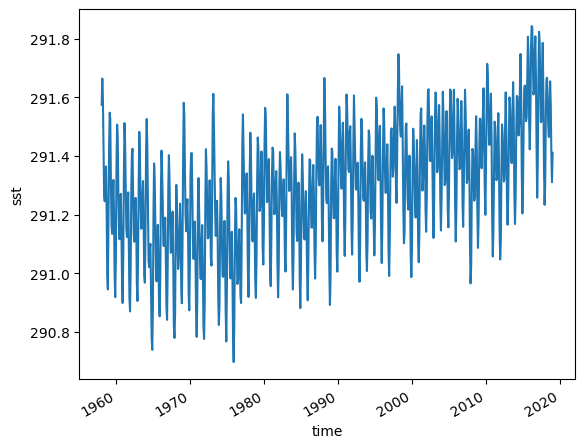

In [14]:
%%time

global_mean = sst.weighted(area.fillna(0)).mean(["xt_ocean", "yt_ocean"])
_ = global_mean.plot()

----------------

## Thoughts/comments

- Using intake-esm results in significantly less tasks in the dask graph for the above computation (550 vs 130,000).

- The intake-esm catalogue here is just a csv file. This presumably wouldn't scale very well to very large numbers of files (I'm not sure at what point things would start to break down - the Pangeo CMIP catalogue uses intake-esm, though these are zarr collections, with far less total files). Should we reach out to NCI to find out more about their new "Python intake" that Ben said is built on a scalable database?

- From my very brief look, there's not a lot of metadata in the COSIMA datasets and there isn't really a standard DRS (e.g. some experiments/realms have an additional OUTPUT directory). This can make indexing difficult. Is model output postprocessing within ACCESS-NRI scope? "postprocessing" could be as simple as adding metadata attributes (e.g. git commit hash) or as complex as aggregating, rechunking etc to make the datasets more "analysis-ready".

In [15]:
client.close()